In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF

In [2]:
tqdm.pandas()

In [6]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [7]:
plt.rcParams.update({'font.size': 15})

In [8]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [9]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]

In [18]:
rows_to_add = []

grouped = billboard_hot_100.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    peak_week = group[group["position"] == group["top_position"]]["first_day_of_the_week"].min()

    for row_index, row in group.iterrows():
        rows_to_add.append({
            "artist_song": row["artist_song"],
            "weeks_on_chart": row["weeks_on_chart"],
            "position": row["position"],
            "first_day_of_the_week": (row["first_day_of_the_week"] - peak_week).days / 7,
            "top_position": row["top_position"],
            "year": row["year"]
        })

100%|██████████| 30408/30408 [01:01<00:00, 491.37it/s]


In [19]:
billboard_100_peaks = pd.DataFrame.from_records(rows_to_add)

## Peak analysis

100%|██████████| 6/6 [00:00<00:00, 24.19it/s]


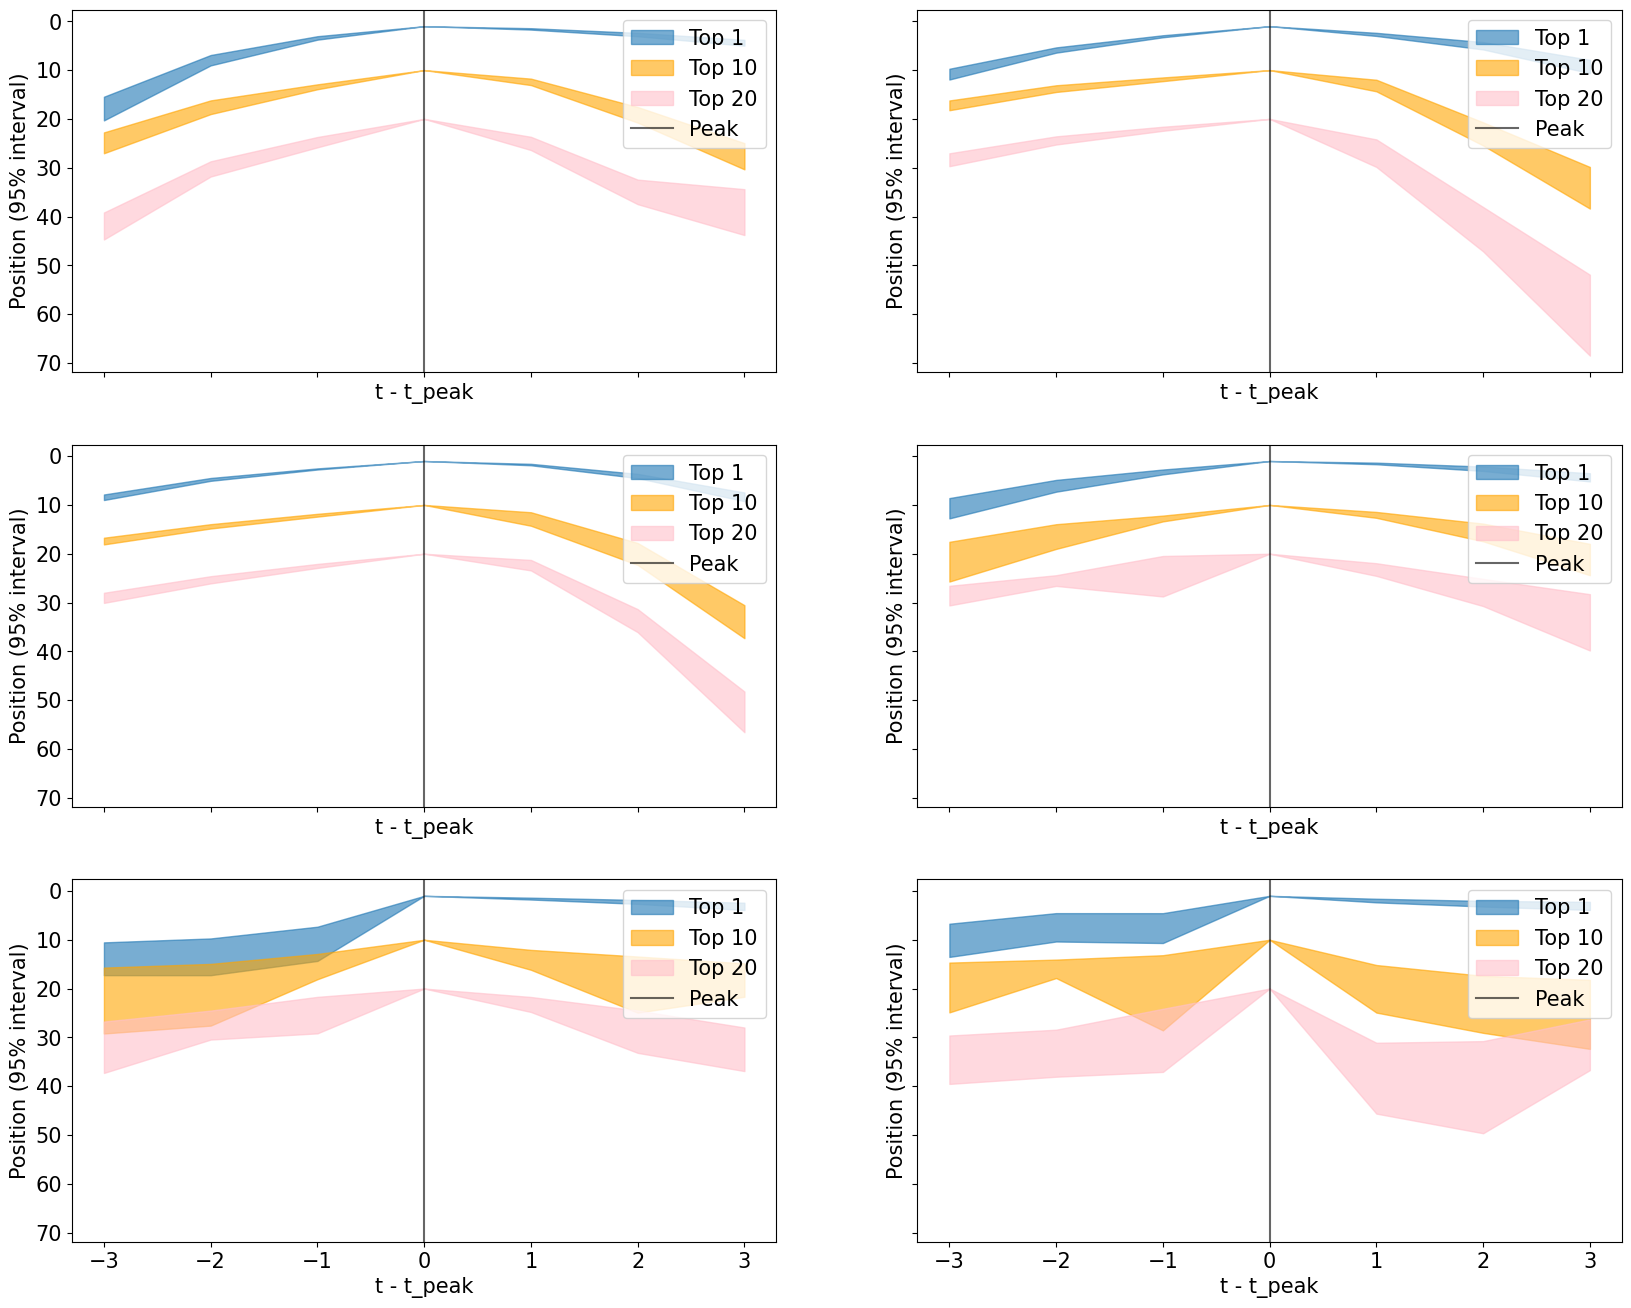

In [68]:

import numpy as np
import scipy.stats as st
  
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True, sharex=True)

col = 0
row = 0

for year in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_100_peaks[(billboard_100_peaks["year"] >= year) &\
        (billboard_100_peaks["year"] < year + 10)][["artist_song", "first_day_of_the_week", "position", "top_position"]]
    songs_from_decade_1 = songs_from_decade[(songs_from_decade["first_day_of_the_week"] >= -3) &\
                                          (songs_from_decade["first_day_of_the_week"] <= 3)  &\
                                            (songs_from_decade["top_position"] == 1)].sort_values(by="first_day_of_the_week")
    confidence_intervals = songs_from_decade_1.groupby("first_day_of_the_week").apply(lambda row: st.t.interval(confidence=0.95, df=len(row["position"])-1,
              loc=np.mean(row["position"]),
              scale=st.sem(row["position"])) if row.name != 0 else (1, 1)).reset_index(name="confidence_interval")
    axes[row, col].fill_between(confidence_intervals["first_day_of_the_week"],
                                    [y[0] for y in confidence_intervals["confidence_interval"]],
                                    [y[1] for y in confidence_intervals["confidence_interval"]], alpha=0.6, color="C0", label="Top 1")
    # top_position == 10
    songs_from_decade_10 = songs_from_decade[(songs_from_decade["first_day_of_the_week"] >= -3) &\
                                          (songs_from_decade["first_day_of_the_week"] <= 3) &\
                                            (songs_from_decade["top_position"] == 10)].sort_values(by="first_day_of_the_week")
    confidence_intervals = songs_from_decade_10.groupby("first_day_of_the_week").apply(lambda row: st.t.interval(confidence=0.95, df=len(row["position"])-1,
              loc=np.mean(row["position"]),
              scale=st.sem(row["position"])) if row.name != 0 else (10, 10)).reset_index(name="confidence_interval")
    axes[row, col].fill_between(confidence_intervals["first_day_of_the_week"],
                                    [y[0] for y in confidence_intervals["confidence_interval"]],
                                    [y[1] for y in confidence_intervals["confidence_interval"]], alpha=0.6, color="orange", label="Top 10")

    # top_position == 20
    songs_from_decade_20 = songs_from_decade[(songs_from_decade["first_day_of_the_week"] >= -3) &\
                                          (songs_from_decade["first_day_of_the_week"] <= 3) &\
                                            (songs_from_decade["top_position"] == 20)].sort_values(by="first_day_of_the_week")
    confidence_intervals = songs_from_decade_20.groupby("first_day_of_the_week").apply(lambda row: st.t.interval(confidence=0.95, df=len(row["position"])-1,
              loc=np.mean(row["position"]),
              scale=st.sem(row["position"])) if row.name != 0 else (20, 20)).reset_index(name="confidence_interval")
    axes[row, col].fill_between(confidence_intervals["first_day_of_the_week"],
                                    [y[0] for y in confidence_intervals["confidence_interval"]],
                                    [y[1] for y in confidence_intervals["confidence_interval"]], alpha=0.6, color="pink", label="Top 20")

    axes[row, col].axvline(0, 100, 0, color="black", alpha=0.6, label="Peak")
    axes[row, col].legend()
    axes[row, col].set_xlabel("t - t_peak")
    axes[row, col].set_ylabel("Position (95% interval)")

    col += 1
    if col == 2:
        row += 1
        col = 0

plt.legend
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 6/6 [00:00<00:00, 21.27it/s]


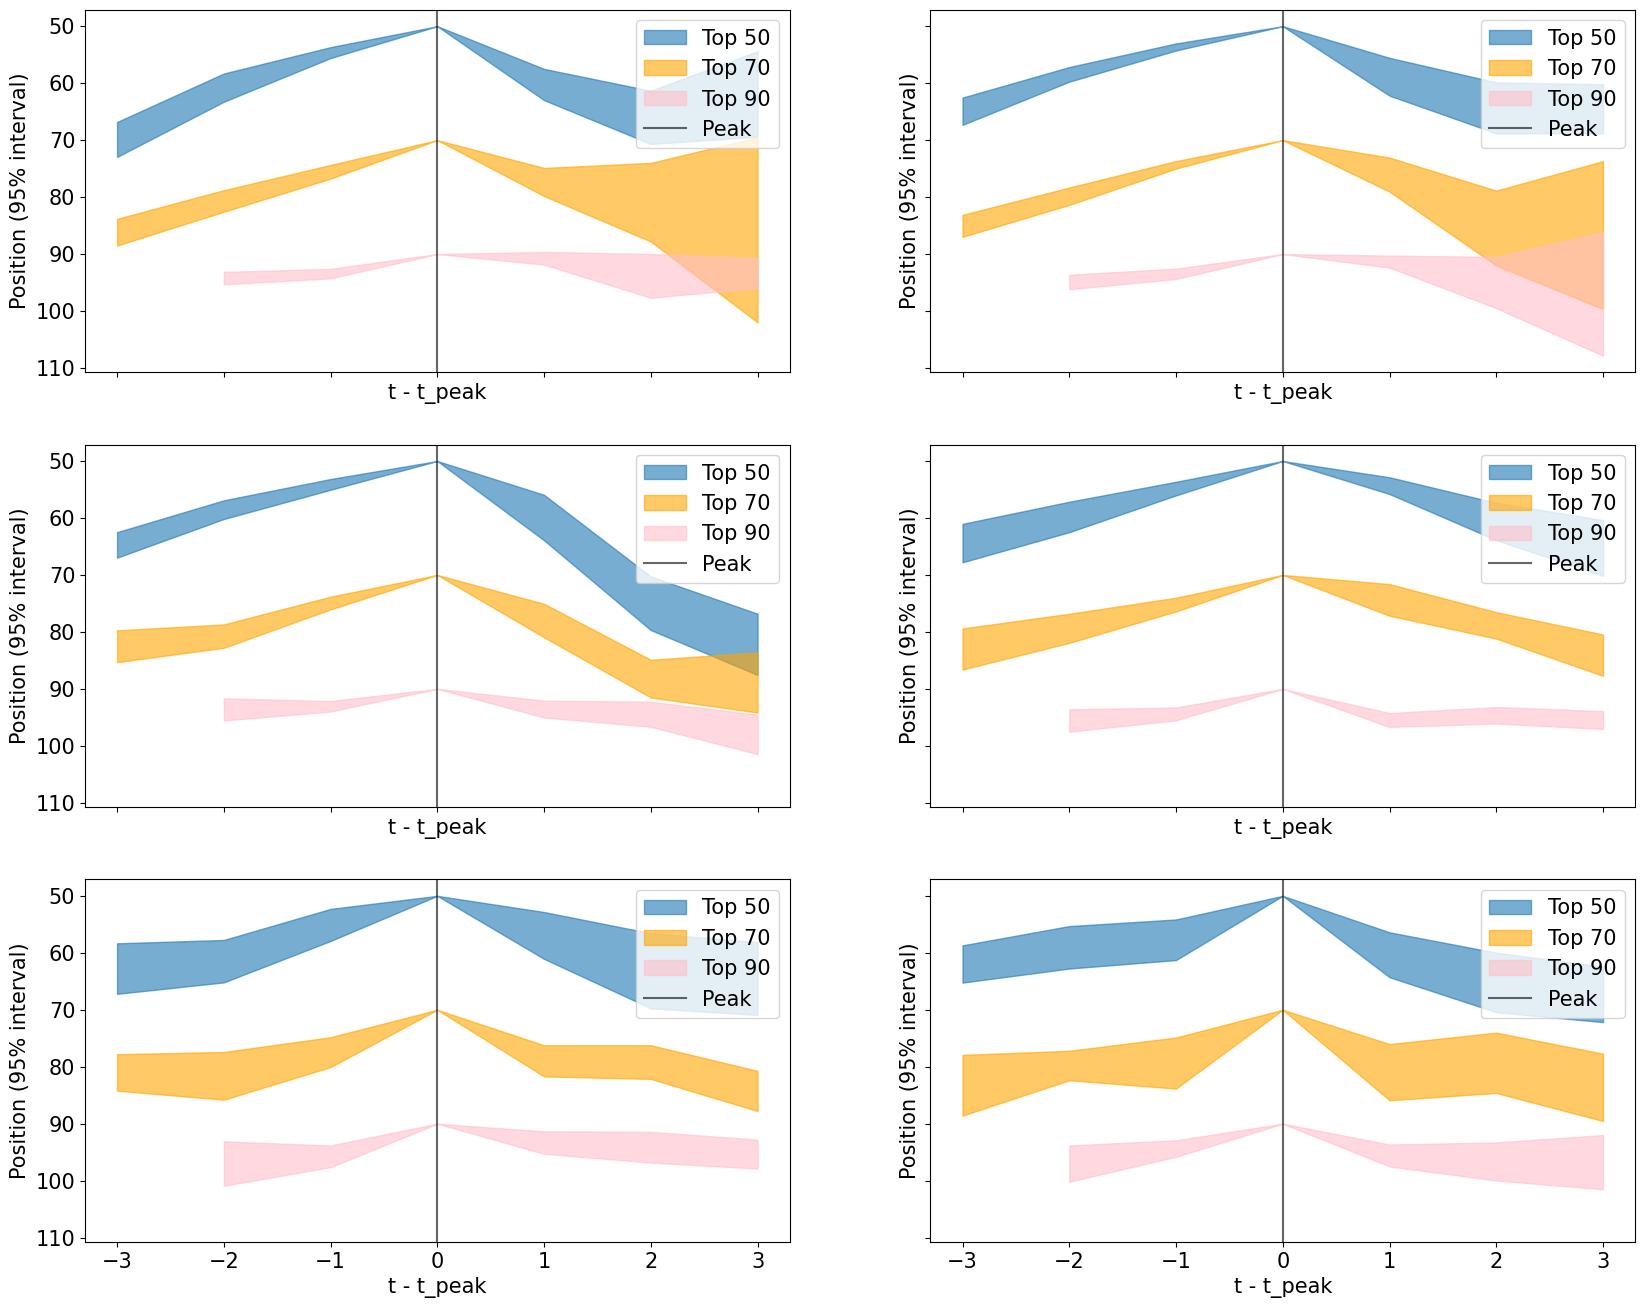

In [69]:

import numpy as np
import scipy.stats as st
  
fig, axes = plt.subplots(3, 2, figsize=(20, 16), sharey=True, sharex=True)

col = 0
row = 0

for year in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_100_peaks[(billboard_100_peaks["year"] >= year) &\
        (billboard_100_peaks["year"] < year + 10)][["artist_song", "first_day_of_the_week", "position", "top_position"]]
    songs_from_decade_50 = songs_from_decade[(songs_from_decade["first_day_of_the_week"] >= -3) &\
                                          (songs_from_decade["first_day_of_the_week"] <= 3)  &\
                                            (songs_from_decade["top_position"] == 50)].sort_values(by="first_day_of_the_week")
    confidence_intervals = songs_from_decade_50.groupby("first_day_of_the_week").apply(lambda row: st.t.interval(confidence=0.95, df=len(row["position"])-1,
              loc=np.mean(row["position"]),
              scale=st.sem(row["position"])) if row.name != 0 else (50, 50)).reset_index(name="confidence_interval")
    axes[row, col].fill_between(confidence_intervals["first_day_of_the_week"],
                                    [y[0] for y in confidence_intervals["confidence_interval"]],
                                    [y[1] for y in confidence_intervals["confidence_interval"]], alpha=0.6, color="C0", label="Top 50")
    # top_position == 70
    songs_from_decade_70 = songs_from_decade[(songs_from_decade["first_day_of_the_week"] >= -3) &\
                                          (songs_from_decade["first_day_of_the_week"] <= 3) &\
                                            (songs_from_decade["top_position"] == 70)].sort_values(by="first_day_of_the_week")
    confidence_intervals = songs_from_decade_70.groupby("first_day_of_the_week").apply(lambda row: st.t.interval(confidence=0.95, df=len(row["position"])-1,
              loc=np.mean(row["position"]),
              scale=st.sem(row["position"])) if row.name != 0 else (70, 70)).reset_index(name="confidence_interval")
    axes[row, col].fill_between(confidence_intervals["first_day_of_the_week"],
                                    [y[0] for y in confidence_intervals["confidence_interval"]],
                                    [y[1] for y in confidence_intervals["confidence_interval"]], alpha=0.6, color="orange", label="Top 70")

    # top_position == 90
    songs_from_decade_90 = songs_from_decade[(songs_from_decade["first_day_of_the_week"] >= -2) &\
                                          (songs_from_decade["first_day_of_the_week"] <= 3) &\
                                            (songs_from_decade["top_position"] == 90)].sort_values(by="first_day_of_the_week")
    confidence_intervals = songs_from_decade_90.groupby("first_day_of_the_week").apply(lambda row: st.t.interval(confidence=0.95, df=len(row["position"])-1,
              loc=np.mean(row["position"]),
              scale=st.sem(row["position"])) if row.name != 0 else (90, 90)).reset_index(name="confidence_interval")
    axes[row, col].fill_between(confidence_intervals["first_day_of_the_week"],
                                    [y[0] for y in confidence_intervals["confidence_interval"]],
                                    [y[1] for y in confidence_intervals["confidence_interval"]], alpha=0.6, color="pink", label="Top 90")

    axes[row, col].axvline(0, 0, 50, color="black", alpha=0.6, label="Peak")
    axes[row, col].legend()
    axes[row, col].set_xlabel("t - t_peak")
    axes[row, col].set_ylabel("Position (95% interval)")

    col += 1
    if col == 2:
        row += 1
        col = 0

plt.legend
plt.gca().invert_yaxis()
plt.show()